In [1]:
from fastai.vision.all import *
set_seed(0)

# Train the model

Note: this is an intentionally poor model; yours will almost certainly be better because your data is better.

In [2]:
train_dataset_path = untar_data('https://students.cs.calvin.edu/~ka37/example_letter_images.zip')
train_images = get_image_files(train_dataset_path)
train_labels = [img.parent.name for img in train_images]

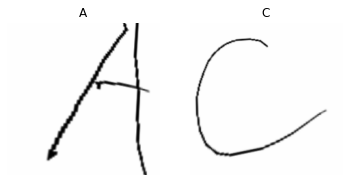

In [3]:
dataloaders = ImageDataLoaders.from_lists(
    path = train_dataset_path, fnames=train_images, labels=train_labels,
    valid_pct=0.2,
    seed=42,
    bs=2,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(size=224)
)
dataloaders.show_batch()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.774597,1.302694,0.400000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.474974,0.858732,0.600000,00:01
1,1.815782,0.381737,1.000000,00:00
2,1.590836,0.292657,0.800000,00:00
3,1.476200,0.351366,1.000000,00:00
4,1.312963,0.610338,0.800000,00:00
5,1.354760,0.798539,0.800000,00:00
6,1.281156,1.066951,0.400000,00:00
7,1.351479,0.615248,0.600000,00:00
8,1.265850,0.768159,0.400000,00:00
9,1.172430,0.743691,0.600000,00:00


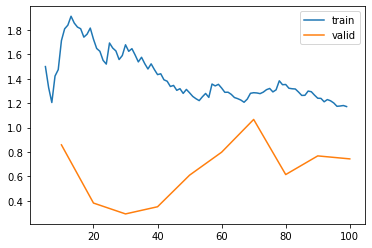

In [4]:
learn = vision_learner(
    dls = dataloaders,
    arch=resnet18,
    metrics=[accuracy]
)
saved_clf_file = Path('classifier.pth')
if saved_clf_file.exists():
    learn.load(saved_clf_file)
else:
    learn.fine_tune(epochs=10)
    learn.recorder.plot_loss()
    learn.save(saved_clf_file)

In [5]:
learn.save(saved_clf_file)

Path('/root/.fastai/data/example_letter_images/models/classifier.pth.pth')

# Load the test set

Here's the code for getting the test set loaded. The basic approach is the same as constructing the DataLoaders above, but instead of making brand new dataloaders, we make a new dataloader that's like the original one but using a new set of images. (This is different than creating a new `dataloaders` because we don't want to split the new data into a training set and validation set; we want to use the whole thing.)

We're giving it the labels so that we can diagnose the results. In a Kaggle-style competition format, you won't get the true labels, so you'll just use `dataloaders.test_dls(test_images, with_labels=False)`.

In [6]:
test_url = 'https://students.cs.calvin.edu/~ka37/letter_images_dataset_v0.zip'
test_dataset_path = untar_data(test_url)

In [7]:
test_images = get_image_files(test_dataset_path)
test_labels = [img.parent.name.upper() for img in test_images]

In [8]:
test_images

(#944) [Path('/root/.fastai/data/letter_images_dataset_v0/c/group_5_c3.jpg'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_9_lower_c_1.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_4_C_0.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_0_C_30.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_0_C_7.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_10_c20.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_1_C_34.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_8_c13.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_1_C_4.png'),Path('/root/.fastai/data/letter_images_dataset_v0/c/group_3_C_0.png')...]

In [9]:
# Note: we need to "zip" the filenames together with the corresponding filenames.
# To see how `zip` works, try looking at the output of `list(zip(test_images[:5], test_labels))`.
test_dl = dataloaders.test_dl(list(zip(test_images, test_labels)), with_labels=True)

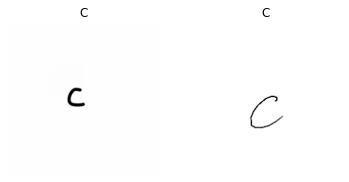

In [10]:
test_dl.show_batch()

# Evaluate our learner on the testing data

Once we have the test `DataLoader`, we can use it for `ClassificationInterpretation`. By default, the *validation* set is used, but we can tell it to use `test_dl` instead:


In [11]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

Here are three basic reports that you might want to look at. (See Chapter 2 of the book.)

In [12]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       0.55      0.55      0.55       332
           B       0.74      0.16      0.27       346
           C       0.45      0.90      0.60       266

    accuracy                           0.51       944
   macro avg       0.58      0.54      0.47       944
weighted avg       0.59      0.51      0.46       944



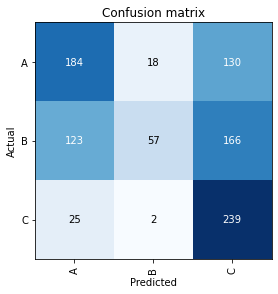

In [13]:
interp.plot_confusion_matrix()

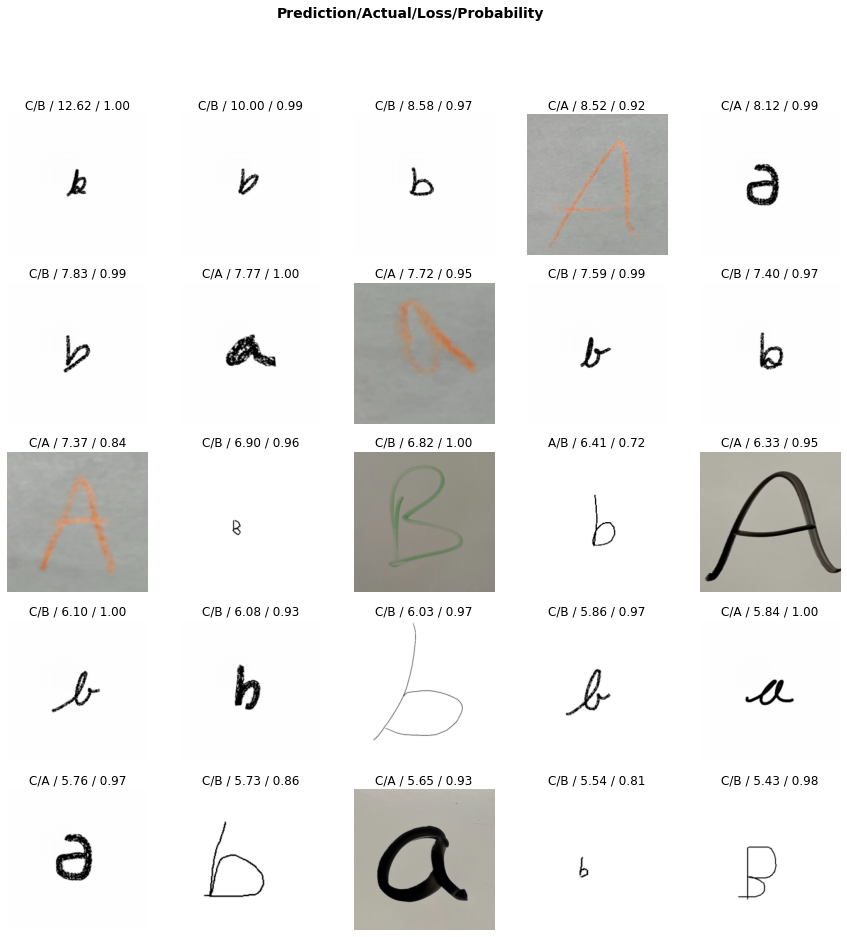

In [14]:
interp.plot_top_losses(25)

Aside: here's the code for getting the predictions manually. [docs](https://docs.fast.ai/learner.html#learner.get_preds)

This works by treating a correct prediction as a 1 and an incorrect prediction as 0. (I call this the *sum-as-count pattern*) This code also demonstrates a clean way to spread out a Python expression over multiple lines: put everything in parentheses.


In [15]:
predicted_probs, targets = learn.get_preds(dl=test_dl, with_preds=True, with_targs=True)
# Use the class with the highest predicted probability as the predicted class.
predicted_classes = predicted_probs.argmax(axis=1)

In [16]:
(
    # Make a Tensor of Trues and Falses, True if the classifier got the corresponding image right
    (
        # the predictions that the model made on the test set
        predicted_classes
        # compare with the target labels provided by the DataLoader (we got these from get_preds above)
        == targets
    )
    # convert True to 1.0, False to 0.0
    .to(float)
    # Compute the fraction of True's.
    .mean()
)

TensorBase(0.5085, dtype=torch.float64)

This also works:

In [17]:
accuracy(predicted_probs, targets)

TensorBase(0.5085)